# Unsupervised GraphSAGE Tutorial

Link prediction and node classification using node embeddings learned with [GraphSAGE](https://arxiv.org/abs/1706.02216).

In [1]:
%matplotlib inline

import os
import random
import numpy as np
import pandas as pd
import networkx as nx
import multiprocessing
import matplotlib.pyplot as plt

In [2]:
# discard warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

!pip install -U 'gast==0.2.2'

Requirement already up-to-date: gast==0.2.2 in /home/dawei/apps/miniconda3.7/lib/python3.7/site-packages (0.2.2)


In [3]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.manifold import TSNE

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator, GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import EdgeSplitter, UnsupervisedSampler

In [4]:
# set random seed
SEED = 101
random.seed(SEED)
np.random.seed(SEED)
tf.set_random_seed(SEED)

## Load the CORA network data

[CORA](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz) is a citation network dataset with 2708 papers (i.e., nodes) and each paper is categorised into one of the following 7 classes:
- Case_Based
- Genetic_Algorithms
- Neural_Networks
- Probabilistic_Methods
- Reinforcement_Learning
- Rule_Learning
- Theory

In [5]:
data_dir = os.path.join('data', 'cora')

Node features (a binary vector that indicates the occurrences of words in a vocabulary with 1433 words) and labels

In [6]:
vocab_size = 1433
feature_names = ['w_{}'.format(i) for i in range(vocab_size)]

In [7]:
node_data = pd.read_csv(os.path.join(data_dir, 'cora.content'), 
                        sep='\t', 
                        header=None, 
                        names=feature_names + ['label'])

Build a graph from edgelists (`cited-paper, citing-paper` pairs)

In [8]:
edgelist = pd.read_csv(os.path.join(data_dir, 'cora.cites'), 
                       sep='\t', 
                       header=None, 
                       names=['target', 'source'])

In [9]:
Gnx = nx.from_pandas_edgelist(edgelist, source='source', target='target')

## Learn node embedding using unsupervised GraphSAGE

Create an undirected stellargraph model with node features

In [10]:
G = sg.StellarGraph(Gnx, node_features=node_data[feature_names])

Create a [node pair generator](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.mapper.GraphSAGELinkGenerator) with the [UnsupervisedSampler](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.data.UnsupervisedSampler), which will generate samples on demand.

In [11]:
unsupervised_sampler = UnsupervisedSampler(G, nodes=list(G.nodes()), length=5, number_of_walks=1)

In [12]:
batch_size = 128
num_samples = [10, 5]

In [13]:
link_gen = GraphSAGELinkGenerator(G, batch_size=batch_size, num_samples=num_samples)
train_gen = link_gen.flow(unsupervised_sampler)

Running GraphSAGELinkGenerator with an estimated 212 batches generated on the fly per epoch.


### Exercise 1
Create a [GraphSAGE](https://stellargraph.readthedocs.io/en/stable/api.html#module-stellargraph.layer.graphsage) model with:
- 2 hidden layers
- the size of both layers is 50
- the link generator created above
- no dropout

In [14]:
# graphsage = # YOUR_CODE

In [15]:
graphsage = GraphSAGE(layer_sizes=[50, 50], 
                      generator=train_gen,
                      dropout=0.0)

Builds a GraphSAGE model for link (i.e., node pair) prediction

In [16]:
x_inp, x_out = graphsage.build()

### Exercise 2

Create a link prediction layer using [link_classification](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.link_inference.link_classification) such that given a node pair (`source`, `target`)
- output the probability that `source` and `target` is connected (i.e., binary classification using `sigmoid` activation)
- scoring the given node pair using the `dot product` of their embeddings

In [17]:
# pred_layer = # YOUR_CODE

In [18]:
pred_layer = link_classification(output_dim=1, output_act='sigmoid', edge_embedding_method='ip')

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [19]:
prediction = pred_layer(x_out)

Create a Keras model that combines node embedding learning and link prediction layers, then train it.

In [20]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

_ = model.fit_generator(
    train_gen,
    epochs=3,
    verbose=1,
    shuffle=True,
    workers=multiprocessing.cpu_count()//2
)

Epoch 1/3
212/212 [==============================] - 26s 121ms/step - loss: 0.5782 - binary_accuracy: 0.7340
Epoch 2/3
212/212 [==============================] - 24s 113ms/step - loss: 0.5476 - binary_accuracy: 0.7711
Epoch 3/3
212/212 [==============================] - 24s 111ms/step - loss: 0.5424 - binary_accuracy: 0.7751


## Extract node embeddings

We first create a node generator using [GraphSAGENodeGenerator](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.mapper.GraphSAGENodeGenerator), note that we want to extract the embeddings of all nodes in the given graph.

In [21]:
node_gen = GraphSAGENodeGenerator(G, batch_size=batch_size, num_samples=num_samples).flow(node_data.index)

### Exercise 3

Create a Keras model so that embeddings of all nodes can be extracted

Hint: making use of `x_inp` and `x_out`, and [this](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.layer.graphsage.GraphSAGE.link_model) documentation might be helpful

In [22]:
# embedding_model = # YOUR_CODE

In [23]:
embedding_model = keras.Model(inputs=x_inp[0::2], outputs=x_out[0])

In [24]:
node_embeddings = embedding_model.predict_generator(node_gen, workers=multiprocessing.cpu_count()//2, verbose=1)

22/22 [==============================] - 1s 60ms/step


### Visualise node embeddings 

In [25]:
X = node_embeddings
y = node_data['label'].astype('category').cat.codes

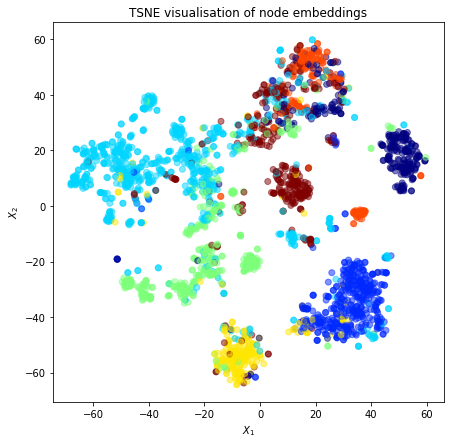

In [26]:
tsne = TSNE(n_components=2)
emb_transformed = pd.DataFrame(tsne.fit_transform(X), index=node_data.index)
emb_transformed['label'] = y

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype('category'), 
           cmap='jet', alpha=.5)
ax.set(aspect='equal', xlabel='$X_1$', ylabel='$X_2$')
plt.title('TSNE visualisation of node embeddings')
plt.show()

## Node classification with learned embeddings

Data splitting

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.05, test_size=None, stratify=y)

Train a multiclass Logistic Regression classifier 

In [28]:
clf = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

Performance on test set

In [29]:
y_pred = clf.predict(X_test)

In [30]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('F1 score: %.3f' % f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.768
F1 score: 0.744
